Author: Amel Docena

In [2]:
import pickle
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import math
import os
import math


In [3]:
os.chdir('/home/ameldocena/.ros/int_preservation/results')

In [4]:
def open_data(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
        f.close()

    return data

In [5]:
#Areas
def store_area_dump(method, worlds, nareas_list, decay_category, nplacements, ntrials, dec_step=None, exp_id=None):
    data = {}
    for w in worlds:
        for n in nareas_list:
            for area in range(n):
                for d in decay_category:
                    for p in range(nplacements):
                        for i in range(ntrials):
                            if method == 'random_decision':
                                data['{}_{}_n{}_p{}_{}_{}_area{}_fmeasure'.format(method, w, n, p+1, d, i+1, area+1)] = open_data('{}_{}_n{}_p{}_{}_{}_area{}_fmeasure.pkl'.format(method, w, n, p+1, d, i+1, area+1))
                                data['{}_{}_n{}_p{}_{}_{}_area{}_status'.format(method, w, n, p+1, d, i+1, area+1)] = open_data('{}_{}_n{}_p{}_{}_{}_area{}_status.pkl'.format(method, w, n, p+1, d, i+1, area+1))
                                data['{}_{}_n{}_p{}_{}_{}_robot0_battery'.format(method, w, n, p+1, d, i+1)] = open_data('{}_{}_n{}_p{}_{}_{}_robot0_battery.pkl'.format(method, w, n, p+1, d, i+1))

                            elif method == 'treebased_decision' or method == 'heuristic_decision' or method == 'dynamic_programming':
                                data['{}_{}_n{}_p{}_{}_k{}_{}_area{}_fmeasure'.format(method, w, n, p+1, d, dec_step, i+1, area+1)] = open_data('{}_{}_n{}_p{}_{}_k{}_{}_{}area{}_fmeasure.pkl'.format(method, w, n, p+1, d, dec_step, i+1, exp_id, area+1))
                                data['{}_{}_n{}_p{}_{}_k{}_{}_area{}_status'.format(method, w, n, p+1, d, dec_step, i+1, area+1)] = open_data('{}_{}_n{}_p{}_{}_k{}_{}_{}area{}_status.pkl'.format(method, w, n, p+1, d, dec_step, i+1, exp_id, area+1))
                                data['{}_{}_n{}_p{}_{}_k{}_{}_robot0_battery'.format(method, w, n, p+1, d, dec_step, i+1, area+1)] = open_data('{}_{}_n{}_p{}_{}_k{}_{}_{}robot0_battery.pkl'.format(method, w, n, p+1, d, dec_step, i+1, exp_id, area+1))
                                data['{}_{}_n{}_p{}_{}_k{}_{}_robot0_decisions_acc_travel'.format(method, w, n, p+1, d, dec_step, i+1)] = open_data('{}_{}_n{}_p{}_{}_k{}_{}_{}robot0_decisions_acc_travel.pkl'.format(method, w, n, p+1, d, dec_step, i+1, exp_id))
                                data['{}_{}_n{}_p{}_{}_k{}_{}_robot0_process_time'.format(method, w, n, p+1, d, dec_step, i+1, area+1)] = open_data('{}_{}_n{}_p{}_{}_k{}_{}_{}robot0_process_time.pkl'.format(method, w, n, p+1, d, dec_step, i+1, exp_id, area+1))
    return data


In [6]:
def chop_data(data, thresh):
    length = []

    for i in data:
        length.append(len(i))
    min_length = min(min(length), thresh)

    chopped_data = []
    for i in data.copy():
        chopped_data.append(i[:min_length])

    return chopped_data

In [7]:
def ave_data(data):
    h, w = len(data), len(data[0])
    array = np.array(data).reshape(h, w)
    mean_data = np.mean(array, axis=0)
    sd_data = np.std(array, axis=0)
    return mean_data, sd_data

In [8]:
def process_data(data_dump, thresh, method, world, nareas, placement, decay, ntrials, dec_step=None):
    chopped_data = dict()
    areas_fmeasure = dict()
    battery = list()
    runtime = list()
    total_travel = list()
    dec_acc = list()

    #Fmeasures
    for area in range(nareas):
        areas_fmeasure[area+1] = list()

    for area in range(nareas):
        for i in range(ntrials):
            if method == 'random_decision':
                areas_fmeasure[area+1].append(data_dump['{}_{}_n{}_p{}_{}_{}_area{}_fmeasure'.format(method, world, nareas, placement, decay, i+1, area+1)])
            elif method == 'treebased_decision' or method == 'heuristic_decision' or method == 'dynamic_programming':
                areas_fmeasure[area+1].append(data_dump['{}_{}_n{}_p{}_{}_k{}_{}_area{}_fmeasure'.format(method, world, nareas, placement, decay, dec_step, i+1, area+1)])
    chop_length = thresh
    for area in range(nareas):
      for trial in range(ntrials):
        chop_length = min(chop_length, len(areas_fmeasure[area+1][trial]))

    secure, caution, crit = [], [], []
    for area in range(nareas):
        chopped_data[area+1] = chop_data(areas_fmeasure[area+1].copy(), chop_length) #Retain here

    #Battery
    chop_length = thresh
    if method == 'random_decision':
      for i in range(ntrials):
        battery_data = data_dump['{}_{}_n{}_p{}_{}_{}_robot0_battery'.format(method, world, nareas, placement, decay, i+1)]
        print("Battery data: {} {}".format(len(battery_data), battery_data))
        chop_length = min(chop_length, len(battery_data))
        battery.append(battery_data)
      battery = chop_data(battery, chop_length)
    elif method == 'treebased_decision' or method == 'heuristic_decision' or method == 'dynamic_programming':
      for i in range(ntrials):
        battery_data = data_dump['{}_{}_n{}_p{}_{}_k{}_{}_robot0_battery'.format(method, world, nareas, placement, decay, dec_step, i+1)]
        runtime_data = data_dump['{}_{}_n{}_p{}_{}_k{}_{}_robot0_process_time'.format(method, world, nareas, placement, decay, dec_step, i+1)]
        dec_data, travel_data = data_dump['{}_{}_n{}_p{}_{}_k{}_{}_robot0_decisions_acc_travel'.format(method, world, nareas, placement, decay, dec_step, i+1)]
        chop_length_batt = min(chop_length, len(battery_data))
        chop_length_runtime = min(chop_length, len(runtime_data))
        battery.append(battery_data)
        runtime.append(runtime_data)
        total_travel.append(travel_data)
        dec_acc.append(dec_data)

      battery = chop_data(battery, chop_length_batt)
      runtime = chop_data(runtime, chop_length_runtime)

    #Return
    if method == 'random_decision':
      return {'fmeasures': chopped_data, 'battery': battery}
    elif method == 'treebased_decision' or method == 'heuristic_decision' or method == 'dynamic_programming':
      return {'fmeasures': chopped_data, 'battery': battery, 'runtime': runtime, 'total_travel': total_travel, 'dec': dec_acc}

In [9]:
def average_trials(chopped_data, type='area'):
    mean_data = dict()
    if type == 'area':
      for area in chopped_data:
        mean_data[area] = ave_data(chopped_data[area])
    else:
      mean_data = ave_data(chopped_data)
    return mean_data

In [10]:
def average_zones(chopped_data, safe_thresh=80, crit_thresh=50):
    bar_secure_arr, bar_caution_arr, bar_critical_arr = [], [], []
    for area in chopped_data:
      data = np.array(chopped_data[area])
      ones = np.ones(data.shape)

      ##Secure zone
      bar_secure = np.sum(ones[data >= safe_thresh])

      ##Caution
      cond = (data < safe_thresh) & (data >= crit_thresh)
      bar_caution = np.sum(ones[cond])

      ##Critical
      bar_critical = np.sum(ones[data < crit_thresh])
      total = bar_secure+bar_caution+bar_critical
      bar_secure_arr.append(bar_secure/total)
      bar_caution_arr.append(bar_caution/total)
      bar_critical_arr.append(bar_critical/total)
    bar_secure_arr = np.array(bar_secure_arr)
    bar_caution_arr = np.array(bar_caution_arr)
    bar_critical_arr = np.array(bar_critical_arr)
    return [np.mean(bar_secure_arr), np.mean(bar_caution_arr), np.mean(bar_critical_arr)], [np.std(bar_secure_arr), np.std(bar_caution_arr), np.std(bar_critical_arr)]

In [11]:
def plot_fzones(plot_zones_dict, colors, nareas):
    """
    Compile results for random, tree-based, heuristic
    """

    #Plot of F-measure of areas
    fig, ax = plt.subplots()
    methods = list(plot_zones_dict.keys())
    labels = ['Secure', 'Caution', 'Critical']

    data, std = plot_zones_dict[methods[0]]
    bottom = 0
    for i, zone_data in enumerate(data):
      ax.bar(methods[0], zone_data, bottom=bottom, yerr=std[i], label=labels[i], color=colors[labels[i]])
      bottom += zone_data

    for method in methods[1:]:
      data, std = plot_zones_dict[method]
      bottom = 0
      for i, zone_data in enumerate(data):
        ax.bar(method, zone_data, bottom=bottom, yerr=std[i], color=colors[labels[i]])
        bottom += zone_data
    ax.set_xlabel('Methods')
    ax.set_ylabel('Percentage')
    # ax.set_title('{} areas'.format(nareas))
    ax.legend(loc='lower right', bbox_to_anchor=(1, 0))
    plt.show()

In [12]:
worlds = ['office']
nareas_list = [4]
decay_category = ['non_uniform']
nplacements = 1
ntrials = 3
thresh = 2000

In [13]:
rand_area_dump = store_area_dump('random_decision', worlds, nareas_list, decay_category, nplacements, ntrials, dec_step=None)
tree4_area_dump = store_area_dump('treebased_decision', worlds, nareas_list, decay_category, nplacements, ntrials, dec_step=4, exp_id='exp40_')
heur2_area_dump = store_area_dump('heuristic_decision', worlds, nareas_list, decay_category, nplacements, ntrials, dec_step=2, exp_id='exp120_')
heur4_area_dump = store_area_dump('heuristic_decision', worlds, nareas_list, decay_category, nplacements, ntrials, dec_step=4, exp_id='exp140_')
heur6_area_dump = store_area_dump('heuristic_decision', worlds, nareas_list, decay_category, nplacements, ntrials, dec_step=6, exp_id='exp160_')
heur8_area_dump = store_area_dump('heuristic_decision', worlds, nareas_list, decay_category, nplacements, ntrials, dec_step=8, exp_id='exp180_')
heur10_area_dump = store_area_dump('heuristic_decision', worlds, nareas_list, decay_category, nplacements, ntrials, dec_step=10, exp_id='exp200_')
heur12_area_dump = store_area_dump('heuristic_decision', worlds, nareas_list, decay_category, nplacements, ntrials, dec_step=12, exp_id='exp220_')
dp4_area_dump = store_area_dump('dynamic_programming', worlds, nareas_list, decay_category, nplacements, ntrials, dec_step=4, exp_id='')

In [14]:
color_palette = dict()
color_palette['R'] = 'gray'
color_palette['T4'] = 'black'
color_palette['H2'] = (0, 125/255, 0)
color_palette['H4'] = 'orange' #(0, 125/255, 125/255)
color_palette['H6'] = (0, 0, 150/255)
color_palette['H8'] = (0, 0, 175/255)
color_palette['H10'] = (0, 0, 100/255)
color_palette['H12'] = (0, 0, 50/255)
color_palette['DP4'] = 'purple'

In [15]:
rand_processed_data_p1 = process_data(rand_area_dump, 2000, 'random_decision', worlds[0], nareas_list[0], nplacements, 'non_uniform', ntrials, None)
tree4_processed_data_p1 = process_data(tree4_area_dump, 2000, 'treebased_decision', worlds[0], nareas_list[0], nplacements, 'non_uniform', ntrials, 4)
heur2_processed_data_p1 = process_data(heur2_area_dump, 2000, 'heuristic_decision', worlds[0], nareas_list[0], nplacements, 'non_uniform', ntrials, 2)
heur4_processed_data_p1 = process_data(heur4_area_dump, 2000, 'heuristic_decision', worlds[0], nareas_list[0], nplacements, 'non_uniform', ntrials, 4)
heur6_processed_data_p1 = process_data(heur6_area_dump, 2000, 'heuristic_decision', worlds[0], nareas_list[0], nplacements, 'non_uniform', ntrials, 6)
heur8_processed_data_p1 = process_data(heur8_area_dump, 2000, 'heuristic_decision', worlds[0], nareas_list[0], nplacements, 'non_uniform', ntrials, 8)
heur10_processed_data_p1 = process_data(heur10_area_dump, 2000, 'heuristic_decision', worlds[0], nareas_list[0], nplacements, 'non_uniform', ntrials, 10)
heur12_processed_data_p1 = process_data(heur12_area_dump, 2000, 'heuristic_decision', worlds[0], nareas_list[0], nplacements, 'non_uniform', ntrials, 12)
dp4_processed_data_p1 = process_data(dp4_area_dump, 2000, 'dynamic_programming', worlds[0], nareas_list[0], nplacements, 'non_uniform', ntrials, dec_step=4)

Battery data: 2045 [99.9, 100, 100, 99.9, 99.80000000000001, 99.70000000000002, 99.60000000000002, 99.50000000000003, 99.40000000000003, 99.30000000000004, 99.20000000000005, 99.10000000000005, 99.00000000000006, 98.90000000000006, 98.80000000000007, 98.70000000000007, 98.60000000000008, 98.50000000000009, 98.40000000000009, 98.3000000000001, 98.2000000000001, 98.10000000000011, 98.00000000000011, 97.90000000000012, 97.80000000000013, 97.70000000000013, 97.60000000000014, 97.50000000000014, 97.40000000000015, 97.30000000000015, 97.20000000000016, 97.10000000000016, 97.00000000000017, 96.90000000000018, 96.80000000000018, 96.70000000000019, 96.6000000000002, 96.5000000000002, 96.4000000000002, 96.30000000000021, 96.20000000000022, 96.10000000000022, 96.00000000000023, 95.90000000000023, 95.80000000000024, 95.70000000000024, 95.60000000000025, 95.50000000000026, 95.40000000000026, 95.30000000000027, 95.20000000000027, 95.10000000000028, 95.00000000000028, 94.90000000000029, 94.8000000000

### Visits made and accomplished



In [16]:
#Location of areas
location_data = open_data('office_n4_sampled_nodes_poses_dict.pkl')

In [17]:
location_data['n4_p1']

[(6.250000689178705, 9.95000059530139),
 (-29.499999843537807, 0.7000004574656487),
 (-18.549999680370092, -23.862499908544123),
 (15.950000833719969, -18.94999983534217)]

In [18]:
#Visits made and accomplished
##Tree4
trial = 0
print("Decisions accomplished: {}. {}".format('T4', tree4_processed_data_p1['dec'][trial]))

##Heur 4
print("Decisions accomplished: {}. {}".format('H4', heur4_processed_data_p1['dec'][trial]))

##DP 4
print("Decisions accomplished: {}. {}".format('DP4', dp4_processed_data_p1['dec'][trial]))

Decisions accomplished: T4. [3, 0, 3, 0, 3, 4, 3, 2, 1, 4, 3, 2, 4, 3, 2, 1, 0, 4, 3, 2, 1, 4, 3, 2, 3, 4, 1, 0, 3, 2]
Decisions accomplished: H4. [3, 4, 3, 2, 4, 3, 2, 1, 4, 3, 2, 4, 0, 3, 2, 4, 1, 2, 3, 4, 1, 2, 3, 4, 0, 3, 2, 1]
Decisions accomplished: DP4. [4, 1, 3, 2, 4, 1, 3, 2, 4, 0, 4, 1, 3, 2, 4, 1, 3, 2, 4, 0, 4, 1]


Performace of deployments through time
1. Cost or total losses of deployment
2. F-measure of areas

In [19]:
def loss_fcn(fmeasure, fmax=100):
  """
  Computes the loss of an F-measure
  """
  loss = (fmax-fmeasure)**2
  return loss

In [20]:
def cost(data, nareas, trial):
  """
  Computes the cost of all fmeasures in areas, which is the sum of their losses

  Inputs:
    data
    nareas - number of areas
  """
  cost = 0

  for area in range(nareas):
    fmeasures_arr = np.array(data['fmeasures'][area+1][trial])
    loss = loss_fcn(fmeasures_arr)
    cost += loss
  return cost


In [21]:
def plot_cost(plot_data, methods, colors, filename):
  """
  PO: We can actually take the average of the trials too

  Plots the cost of the deployment through time
  """
  fig, ax = plt.subplots()
  for method in methods:
    plot = plot_data[method]
    x_arr = list(range(len(plot)))
    ax.plot(x_arr, plot, label=method, color=colors[method])
  ax.set_xlabel("Time")
  ax.set_ylabel("Total losses")
  ax.legend(loc='best')
  if filename is not None:
    plt.savefig(filename)
  plt.show()

In [22]:
def plot_cost_ratio(plot_data, baseline, methods, colors):
  """
  Plots the ratio of costs between baseline and methods
  """

  fig, ax = plt.subplots()
  for method in methods:
    error = plot_data[method]/plot_data[baseline]
    x_arr = list(range(len(error)))
    ax.plot(x_arr, error, color=colors[method], label='{}:{}'.format(method, baseline))
  ax.axhline(1, linestyle='dashed', color='black')
  ax.set_xlabel("Time")
  ax.set_ylabel("Ratio of total losses")
  ax.legend(loc='best')
  plt.show()

In [23]:
def plot_cost_growth(plot_data, baseline, methods, colors):
  """
  Plots the growth/savings in error by applying baseline instead
  """

  fig, ax = plt.subplots()
  for method in methods:
    error = (plot_data[baseline]-plot_data[method])/plot_data[method]
    x_arr = list(range(len(error)))
    ax.plot(x_arr, error, color=colors[method], label='{}, {}'.format(baseline, method))
  ax.axhline(0, linestyle='dashed', color='black')
  ax.set_xlabel("Time")
  ax.set_ylabel("Total losses growth")
  ax.legend(loc='best')
  plt.show()

In [24]:
def compute_average_costs(cost_data, methods):
  """
  Computes the average cost of data
  """
  mean_data = list()
  for method in methods:
    mean_data.append(np.mean(cost_data[method]))
  return mean_data

In [25]:
def elbow_method(average_costs, k_list, filename=None):
  """
  Plots the average cost per k decision step
  """
  x = list(range(len(average_costs)))
  plt.plot(x, average_costs)
  plt.scatter(x, average_costs)
  plt.xticks(x, labels=k_list)
  plt.xlabel('k')
  plt.ylabel('Average total losses')
  if filename is not None:
    plt.savefig(filename)
  plt.show()

In [26]:
rand_trial = 2
trial = 1
nareas = 4

rand_cost = cost(rand_processed_data_p1, nareas, rand_trial)
tree4_cost = cost(tree4_processed_data_p1, nareas, trial)
heur2_cost = cost(heur2_processed_data_p1, nareas, trial)
heur4_cost = cost(heur4_processed_data_p1, nareas, trial)
heur6_cost = cost(heur6_processed_data_p1, nareas, trial)
heur8_cost = cost(heur8_processed_data_p1, nareas, trial)
heur10_cost = cost(heur10_processed_data_p1, nareas, trial)
dp4_cost = cost(dp4_processed_data_p1, nareas, trial)

cost_data = dict()
cost_data['R'] = rand_cost
cost_data['T4'] = tree4_cost
cost_data['H2'] = heur2_cost
cost_data['H4'] = heur4_cost
cost_data['H6'] = heur6_cost
cost_data['H8'] = heur8_cost
cost_data['H10'] = heur10_cost
cost_data['DP4'] = dp4_cost

Tuning k

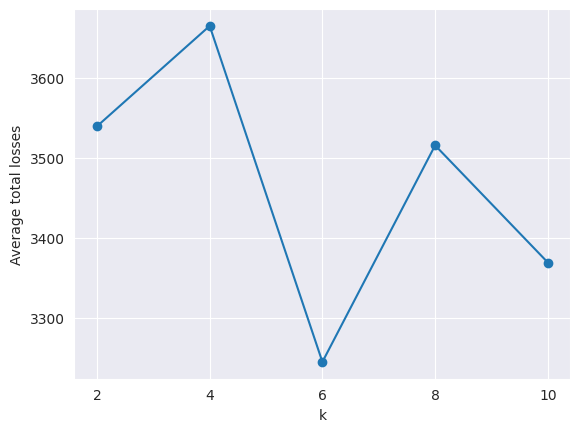

In [27]:
average_costs = compute_average_costs(cost_data, ['H2', 'H4', 'H6', 'H8', 'H10'])
elbow_method(average_costs, [2, 4, 6, 8, 10], filename='elbow_office_quad4.pdf') #TODO

Estimate the approximation ratio beforehand. Perhaps by taking the average for the parameters used for estimating the bound


In [28]:
def decay(delta, tlapse, max_fmeasure=100):
  """
  Returns the decayed value from max F-measure given delta and time elapsed
  """
  decay = max_fmeasure*math.exp(-delta*tlapse)
  return decay

In [29]:
def marginal_loss(delta, time, max_fmeasure=100):
  ml = 2*(max_fmeasure - decay(delta, time, max_fmeasure))
  return ml

In [30]:
def get_time_given_decay(decayed_fmeasure, rate, max_fmeasure=100):
    """
    Retrieves time given decayed measure and decay rate (by inversion)
    :param decayed_measure:
    :param rate:
    :return:
    """
    t = math.log(decayed_fmeasure/max_fmeasure) / math.log(1.0-rate)

    return t

In [31]:
def est_time_elapsed(fmeasures_data, decay_rates, nareas, trial):
  """
  Measures the time that has elapsed since last restoration.
  """
  tlapse = list()
  for area in range(nareas):
    fdata = fmeasures_data['fmeasures'][area+1][trial]
    for i in range(len(fdata)):
      if (i-1>0 and i+1<len(fdata)) and fdata[i-1] >= fdata[i] and fdata[i+1] > fdata[i]:
        f = fdata[i]
        t = get_time_given_decay(f, decay_rates[area])
        tlapse.append(t)
  return sorted(tlapse)

#### Time elapsed below the critical threshold
1. For each area, measure the time elapsed
2. Filter out those that area below the critical threshold
3. Sum for each area
4. Sum the total of areas, measure the average and sd

In [32]:
def stats_time_below_crit(processed_data, decay_rates, crit, trial):
  """
  Measures the time elapsed that areas area below the crit threshold before it gets restored
  How:
  1. Extract those that have fallen below the crit thresh
  2. Get their time given decay
  3. Run the succeeding linear search

  #Output: Average t (s.d) for each area. Average t (s.d.) for all areas
  """
  fmeasures = processed_data['fmeasures']
  nareas = len(fmeasures.keys())
  area_time_below_crit = list() #container for each area below the crit
  tareas_time_below_crit = list() #container for all areas below the crit
  data = dict() #data of time given decayed measure and decay rate

  for area in range(nareas):
    data[area+1] = list()
    for f in fmeasures[area+1][trial]:
      data[area+1].append(get_time_given_decay(f, decay_rates[area]))

  #Step 0. For each area measure the time elapsed
  for area in range(nareas):
    t = np.array(data[area+1])
    f = np.array(fmeasures[area+1][trial])
    tcrit = get_time_given_decay(50, decay_rates[area])
    time_crit = t[f < crit] - tcrit
    print("Time crit:", len(time_crit), np.nanmean(time_crit), np.nanstd(time_crit))

    #Collect time prior to restoration per area
    times_before_restored = list()
    for t in range(len(time_crit)-1):
      # print(t, time_crit[t])
      trestored = None
      #Any restorations prior to end of data
      if (time_crit[t-1] < time_crit[t]) and (time_crit[t] > time_crit[t+1]):
        if t < len(time_crit):
          trestored = time_crit[t]
          times_before_restored.append(time_crit[t])
          tareas_time_below_crit.append(time_crit[t])
      #Time lapsed at end of data
      elif trestored == None and t >= len(time_crit)-2:
        trestored = time_crit[t]
        times_before_restored.append(time_crit[t])
        tareas_time_below_crit.append(time_crit[t])

    #Store (average, sd) for each area
    area_time_below_crit.append((np.round(np.nanmean(times_before_restored), 2), np.round(np.nanstd(times_before_restored), 2)))

  #Step 3. Measure (average, sd) of all areas
  tareas_time_below_crit = np.array(tareas_time_below_crit)
  ave_time, sd = np.round(np.nanmean(tareas_time_below_crit), 2), np.round(np.nanstd(tareas_time_below_crit), 2)
  #Step 5. Return and print stats for each area, their total, the average, and sd
  print("Ave. Time per area: {}. Average: {}. SD: {}".format(area_time_below_crit, ave_time, sd))
  return area_time_below_crit, ave_time, sd


In [33]:
crit=50
decay_rates = [0.00124, 0.00168, 0.00224, 0.00255]
tstats_t4 = stats_time_below_crit(tree4_processed_data_p1, decay_rates, crit, trial)
tstats_h4 = stats_time_below_crit(heur4_processed_data_p1, decay_rates, crit, trial)
tstats_dp4 = stats_time_below_crit(dp4_processed_data_p1, decay_rates, crit, trial)

Time crit: 33 16.835419421285902 9.509842687589176
Time crit: 9 4.251378821976648 2.577617564601778
Time crit: 0 nan nan
Time crit: 190 48.20172203165966 40.99311925834911
Ave. Time per area: [(31.82, 0.0), (7.25, 0.0), (nan, nan), (46.14, 48.8)]. Average: 37.27. SD: 42.37
Time crit: 33 16.835419421285902 9.509842687589176
Time crit: 20 9.741985993490738 5.756428160968091
Time crit: 186 50.49713793012444 33.00475966364468
Time crit: 259 52.71409440001751 41.88876367781236
Ave. Time per area: [(31.82, 0.0), (18.23, 0.0), (91.67, 28.42), (63.09, 52.51)]. Average: 60.72. SD: 46.4
Time crit: 0 nan nan
Time crit: 125 62.14621571636116 36.015828240106664
Time crit: 465 76.65089829468641 61.02640175342582
Time crit: 409 50.51802075910176 29.448157777065195
Ave. Time per area: [(nan, nan), (123.03, 0.0), (115.1, 65.98), (100.73, 1.41)]. Average: 109.59. SD: 44.77


/tmp/ipykernel_7767/4009876265.py:28: RuntimeWarning: Mean of empty slice
  print("Time crit:", len(time_crit), np.nanmean(time_crit), np.nanstd(time_crit))
/home/ameldocena/catkin_ws/src/intermittent_preservation/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_7767/4009876265.py:48: RuntimeWarning: Mean of empty slice
  area_time_below_crit.append((np.round(np.nanmean(times_before_restored), 2), np.round(np.nanstd(times_before_restored), 2)))


In [34]:
print("\nTimestats: T4", tstats_t4)
print("\nTimestats: H4", tstats_h4)
print("\nTimestats: DP4", tstats_dp4)


Timestats: T4 ([(31.82, 0.0), (7.25, 0.0), (nan, nan), (46.14, 48.8)], 37.27, 42.37)

Timestats: H4 ([(31.82, 0.0), (18.23, 0.0), (91.67, 28.42), (63.09, 52.51)], 60.72, 46.4)

Timestats: DP4 ([(nan, nan), (123.03, 0.0), (115.1, 65.98), (100.73, 1.41)], 109.59, 44.77)


#### Total losses

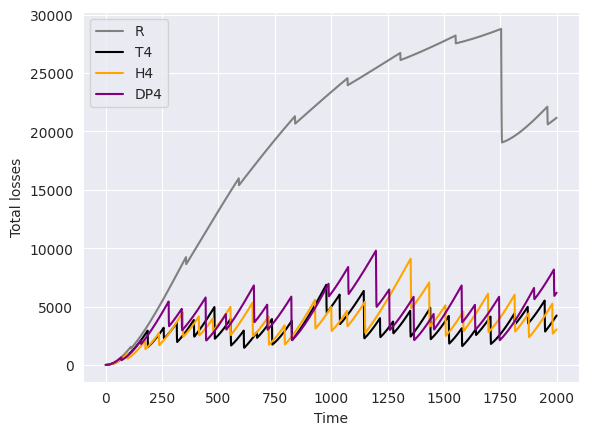

In [35]:
plot_cost(cost_data, ('R', 'T4', 'H4', 'DP4'), color_palette, filename='total_losses_office_quad4.pdf') #TODO

/tmp/ipykernel_7767/1106313823.py:8: RuntimeWarning: invalid value encountered in divide
  error = plot_data[method]/plot_data[baseline]


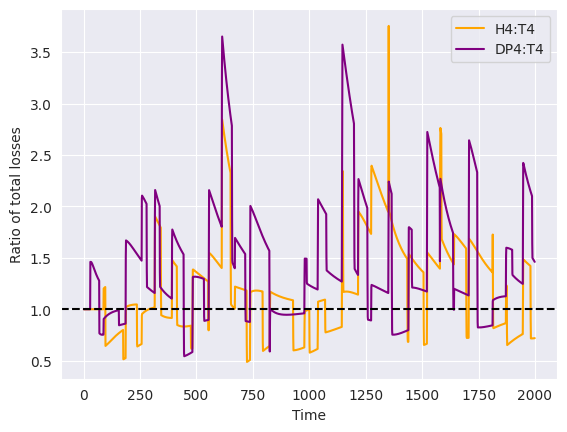

In [36]:
plot_cost_ratio(cost_data, baseline='T4', methods=['H4', 'DP4'], colors=color_palette)

/tmp/ipykernel_7767/1106313823.py:8: RuntimeWarning: invalid value encountered in divide
  error = plot_data[method]/plot_data[baseline]


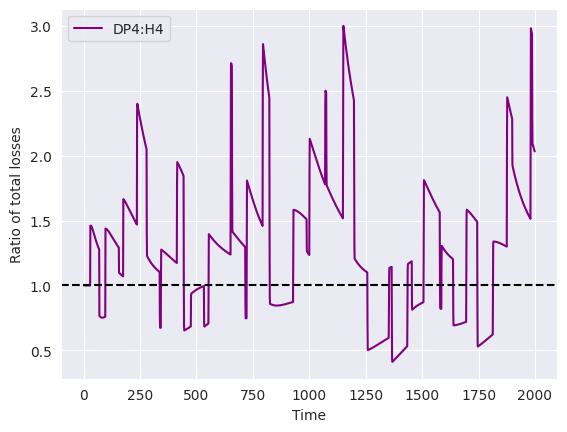

In [37]:
plot_cost_ratio(cost_data, baseline='H4', methods=['DP4'], colors=color_palette)

In [38]:
def histogram_cost_ratio(plot_data, compare_list, colors, alpha=1, filename=None):
  """
  Plots the ratio of costs between baseline and methods
  """

  fig, ax = plt.subplots()
  for compare in compare_list:
    method, baseline = compare
    error = plot_data[method]/plot_data[baseline]
    ave, sd = np.nanmean(error), np.nanstd(error)
    print("Average ratio {}:{}={}, SD={}".format(method, baseline, ave, sd))
    x_arr = list(range(len(error)))
    ax.hist(error, color=colors[method], label='{}:{}'.format(method, baseline), alpha=alpha, orientation='horizontal')
    ax.axhline(ave, linestyle='--', color=colors[method])
  ax.set_xlabel("Frequency")
  ax.set_ylabel("Relative ratio of total losses")
  ax.legend(loc='best')
  if filename is not None:
    plt.savefig(filename)
  plt.show()

Average ratio DP4:T4=1.4776951486016987, SD=0.613353623794395
Average ratio H4:T4=1.2201795005062888, SD=0.46439824734643254


/tmp/ipykernel_7767/4034043055.py:9: RuntimeWarning: invalid value encountered in divide
  error = plot_data[method]/plot_data[baseline]


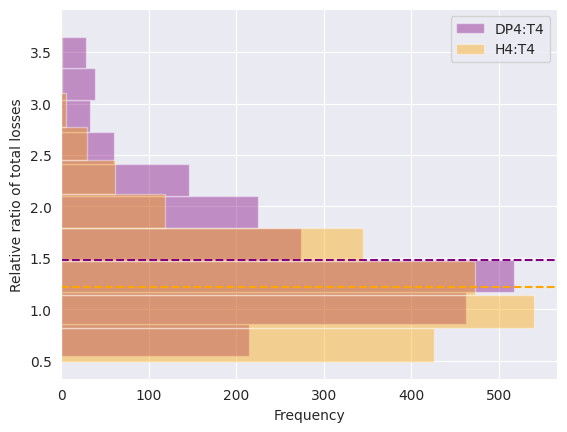

In [39]:
histogram_cost_ratio(cost_data, [('DP4', 'T4'), ('H4', 'T4')], colors=color_palette, alpha=0.40, filename='hist_rratio_office_quad4.pdf') #TODO

Histogram of relative ratios of total losses between a method and (T), wherein the dashed horizontal line marks the corresponding average ratio. A relative ratio that is above 1 means that the total losses of the method is greater than (T), and the higher the ratio the greater the magnitude. If one method's relative ratio is greater than that of another, it follows that the latter performs better.

#### Ratio to the optimal
Ratios greater than 1, especially the larger ratios, are more frequent in (DP4) than in (H4). And that, the average of (DP4) is 1.41 (sd=0.55), while that of (H4) 1.02 (sd=0.41). H4 performs closer to (T) and better than (DP4) most of the time.


In [40]:
def ave_cost_ratio(cost_data, baseline, method):
  """
  Computes the average cost ratio for which the cost of the method exceeds the baseline
  """
  baseline_cost = cost_data[baseline]
  method_cost = cost_data[method]
  cost_ratio = method_cost/baseline_cost
  condition = cost_ratio > 1.0
  ave_cost_ratio = np.mean(cost_ratio[condition])
  return ave_cost_ratio

In [41]:
print("Average cost ratio where method exceeds baseline:", ave_cost_ratio(cost_data, 'T4', 'H4'))

Average cost ratio where method exceeds baseline: 1.4880170747759192


/tmp/ipykernel_7767/1596469089.py:7: RuntimeWarning: invalid value encountered in divide
  cost_ratio = method_cost/baseline_cost


Comments:
1. What is that large error? Why does it occur? Did the robot get stuck? Or is this a charging decision?  
a. Check the battery, when does it charge?

Performance per area
1. How is the preservation of F-measure in each area through time?

In [42]:
def plot_fmeasures(plot_data_dict, methods, colors, safe_thresh=80, crit_thresh=50):
    """
    Compile results for random, tree-based, heuristic
    """

    #Plot of F-measure of areas
    # plt.figure()
    fig, ax = plt.subplots()
    for method in methods:
      plot_data = plot_data_dict[method]
      nareas = len(plot_data)
      compile_data = list()
      length = len(plot_data[1])
      x_arr = list(range(length))
      for area in range(nareas):
          compile_data.append(plot_data[area+1])

      #Average and error bar
      ave_f = np.mean(compile_data, axis=0)
      std_f = np.std(compile_data, axis=0)
      average, sd = np.mean(compile_data), np.std(compile_data)
      print("Method: {}. Average: {}. SD: {}".format(method, average, sd))
      ax.plot(x_arr, ave_f, label=method, color=colors[method])
      # ax.errorbar(x_arr[::math.floor(length/100)], ave_f[::math.floor(length/100)], yerr=std_f[::math.floor(length/100)], color=colors[method], fmt='--', alpha=0.25)
    ax.axhline(crit_thresh, linestyle='dashed', color='red', label='Crit')
    ax.set_xlabel("Time")
    ax.set_ylabel("F-measure")
    ax.set_ylim(0, 100)
    # ax.set_title("{} areas".format(nareas))
    ax.legend(loc='best')
    plt.show()

In [43]:
def get_fmeasures_trial(processed_data, trial, interval=None):
  trial_data = dict()
  for area in processed_data['fmeasures']:
    trial_data[area] = processed_data['fmeasures'][area][trial]
    if interval is not None:
      trial_data[area] = processed_data['fmeasures'][area][trial][::interval]
  return trial_data

In [44]:
interval = 50
plot_data_dict = dict()
plot_data_dict['R'] = get_fmeasures_trial(rand_processed_data_p1, rand_trial, interval)
plot_data_dict['T4'] = get_fmeasures_trial(tree4_processed_data_p1, trial, interval)
plot_data_dict['H4'] = get_fmeasures_trial(heur4_processed_data_p1, trial, interval)
plot_data_dict['DP4'] = get_fmeasures_trial(dp4_processed_data_p1, trial, interval)

Method: R. Average: 41.70873125483903. SD: 35.13974160556135
Method: T4. Average: 76.5119698339718. SD: 14.506112768166673
Method: H4. Average: 74.04435225319466. SD: 15.72572540655595
Method: DP4. Average: 72.11267285467716. SD: 16.881200676592904


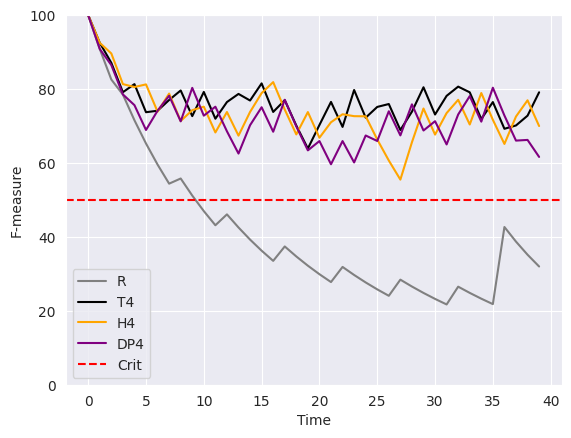

In [45]:
#Average F-measure per area
plot_fmeasures(plot_data_dict, ('R', 'T4', 'H4', 'DP4'), color_palette)

In [46]:
def histogram_avef_ratio(plot_data, baseline, methods, colors, alpha=1):
  """
  Plots the ratio of average F between baseline and methods
  """

  fig, ax = plt.subplots()
  for method in methods:
    error = plot_data[method]/plot_data[baseline]
    ave, sd = np.nanmean(error), np.nanstd(error)
    print("Average ratio: {}, SD: {}".format(ave, sd))
    x_arr = list(range(len(error)))
    ax.hist(error, color=colors[method], label='{}:{}'.format(method, baseline), alpha=alpha, orientation='horizontal')
    ax.axhline(ave, linestyle='--', color=colors[method])
  # ax.axhline(1, linestyle='-.', color='black')
  ax.set_xlabel("Frequency")
  ax.set_ylabel("Ratio of total losses")
  ax.legend(loc='best')
  plt.show()

In [47]:
def transform_pandas_long(arr_data, thresh, nareas, interval=None):
  length = min(thresh, len(arr_data[1]))
  compile_data = [[interval*i for i in range(length)]]
  for area in range(nareas):
      compile_data.append(arr_data[area+1])
  compile_data = np.array(compile_data)

  #Create pandas
  columns = ['time']
  columns.extend(['area{}'.format(area+1) for area in range(compile_data.shape[0]-1)])
  index = list(range(compile_data.shape[1]))

  # Convert the NumPy array to a Pandas DataFrame with custom labels
  df = pd.DataFrame(compile_data.T, columns=columns, index=index)

  #Transform to long form
  df_long = pd.melt(df, id_vars = 'time', var_name = 'area', value_name = 'fmeasure')
  return df_long

In [48]:
def ave_fmeasures_plot(data_dict, methods, thresh, nareas, crit_thresh, interval=None, filename=None):
  """
  Plots with average measure and confidence interval as area of the CI curve
  """

  for method in methods:
    plot_data = transform_pandas_long(data_dict[method], thresh, nareas, interval)
    sns.lineplot(data=plot_data, x='time', y='fmeasure', label=method, color=color_palette[method])
  plt.ylim(0, 100)
  plt.xlim(0, max(2000, thresh))
  plt.axhline(crit_thresh, linestyle='dashed', color='red', label='Crit')
  plt.xlabel('Time')
  plt.ylabel('F-measure')
  plt.legend()
  if filename is not None:
    plt.savefig(filename)
  plt.show()

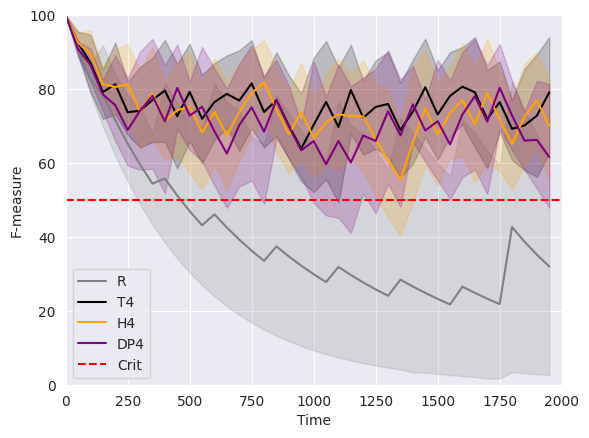

In [49]:
crit_thresh = 50
ave_fmeasures_plot(plot_data_dict, ['R', 'T4', 'H4', 'DP4'], thresh, nareas_list[0], crit_thresh, interval, filename='avef_office_quad4.pdf') #TODO

In [50]:
from matplotlib.animation import FFMpegWriter

In [51]:
rand_trial = 0
animate_data_dict = dict()
animate_data_dict['T4'] = get_fmeasures_trial(tree4_processed_data_p1, trial)
animate_data_dict['H4'] = get_fmeasures_trial(heur4_processed_data_p1, trial)
animate_data_dict['DP4'] = get_fmeasures_trial(dp4_processed_data_p1, trial)
animate_data_dict['R'] = get_fmeasures_trial(rand_processed_data_p1, rand_trial)

In [52]:
import matplotlib.animation as animation

In [53]:
def animate_fmeasures(plot_data, methods, thresh, filename, fps, nareas=4, crit_thresh=50, colors=None):
    """
    #Credits: codinglikemad
    Animates the fmeasures
    We create a plot, then for each area animate
    """
    fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
    
    indices = [(0, 0), (0, 1), (1, 0), (1, 1)]
    
    def update(frames):
        for area in range(nareas):
            for method in methods:
                if method == 'T4':
                    label_m = 'T'
                elif method == 'H4':
                    label_m = 'H'
                elif method == 'DP4':
                    label_m = 'DP'
                else:
                    label_m = 'R'
                idx_x, idx_y = indices[area]
                ydata = plot_data[method][area+1][:frames]
                x_arr = list(range(frames))
                ax[idx_x, idx_y].plot(x_arr, ydata, label=label_m, color=colors[method])
                ax[idx_x, idx_y].axhline(crit_thresh, linestyle='dashed', color='red')
                ax[idx_x, idx_y].axhline(50, linestyle='dashed', color='red')
                if area+1 == 1:
                    rate = 'slowest'
                elif area+1 == 2:
                    rate = 'slow'
                elif area+1 == 3:
                    rate = 'fast'
                elif area+1 == 4:
                    rate = 'fastest'
                ax[idx_x, idx_y].set_title("Area {} ({})".format(area+1, rate))
                ax[idx_x, idx_y].set_xlabel('Time')
                ax[idx_x, idx_y].set_ylabel('F-measure')
                ax[idx_x, idx_y].set_xlim((0, thresh))
                ax[idx_x, idx_y].set_ylim((0, 100))
        fig.tight_layout()
    ani = animation.FuncAnimation(fig, update, frames=range(0, thresh, fps // 10))
    ani.save(filename, writer='imagemagick', fps=fps)

In [54]:
# animate_fmeasures(animate_data_dict, ['T4', 'H4'], thresh, filename='t_h.gif', fps=100, colors=color_palette)

In [55]:
# animate_fmeasures(animate_data_dict, ['R', 'DP4'], thresh, filename='r_dp.gif', fps=100, colors=color_palette)

In [56]:
def plot_fmeasures_per_area(plot_data, methods, thresh, nareas=4, crit_thresh=50, colors=None, filename=None):
  """
  Animates the fmeasures
  We create a plot, then for each area animate
  """
  fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

  indices = [(0, 0), (0, 1), (1, 0), (1, 1)]

  for area in range(nareas):
    for method in methods:
      x_length = min(thresh, len(plot_data[method][area+1]))
  x_arr = list(range(x_length))

  for area in range(nareas):
    for method in methods:
      if method == 'T4':
          label_m = 'T'
      elif method == 'H4':
          label_m = 'H'
      elif method == 'DP4':
          label_m = 'DP'
      else:
          label_m = 'R'
      idx_x, idx_y = indices[area]
      ydata = plot_data[method][area+1]
      ax[idx_x, idx_y].plot(x_arr, ydata, label=label_m, color=colors[method])
      ax[idx_x, idx_y].axhline(crit_thresh, linestyle='dashed', color='red')
      if area+1 == 1:
        rate = 'slowest'
      elif area+1 == 2:
        rate = 'slow'
      elif area+1 == 3:
        rate = 'fast'
      elif area+1 == 4:
        rate = 'fastest'
      ax[idx_x, idx_y].set_title("Area {} ({})".format(area+1, rate))
      ax[idx_x, idx_y].set_xlabel('Time')
      ax[idx_x, idx_y].set_ylabel('F-measure')
      ax[idx_x, idx_y].set_xlim((0, thresh))
      ax[idx_x, idx_y].set_ylim((0, 100))
  handles, labels = ax[1, 1].get_legend_handles_labels()
  fig.legend(handles, labels, bbox_to_anchor=(1.10, 0.50), loc='right')
  fig.tight_layout()
  if filename is not None:
    fig.savefig(filename, bbox_inches='tight')
    # fig.savefig(filename)
  fig.show()

/tmp/ipykernel_7767/2088964015.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


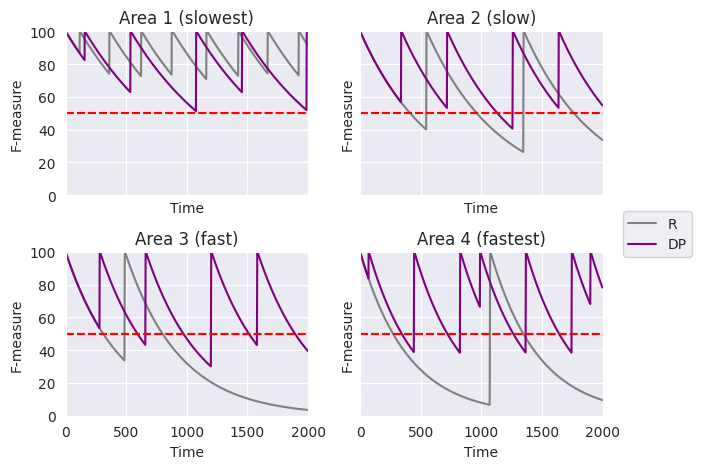

In [57]:
plot_fmeasures_per_area(animate_data_dict, ['R', 'DP4'], thresh, colors=color_palette, filename='r_dp.pdf')

/tmp/ipykernel_7767/2088964015.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


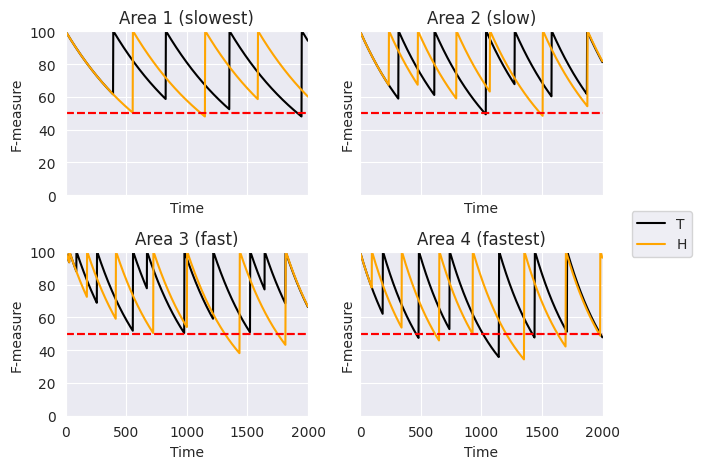

In [58]:
plot_fmeasures_per_area(animate_data_dict, ['T4', 'H4'], thresh, colors=color_palette, filename='t_h.pdf')

In [79]:
#Create decaying functions for the spatio-temporal areas
#In one plot, for the four areas with their decay rates, animate the plot that it is decaying
def animate_decay(decay_rates, tframe, crit=50):
    """
    
    :param decay_rates: 
    :return: 
    """
    x = list(range(tframe))
    colors = {'A1': 'green', 'A2': 'blue', 'A3': 'skyblue', 'A4': 'maroon'}
    
    for area in decay_rates:
        y = [decay(decay_rates[area], t) for t in x]
        plt.plot(x, y, label=area, color=colors[area], linestyle='--')
    
    # Add labels and title
    plt.axhline(crit, color='red', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('F-measure')
    plt.legend()
    plt.show()    
    


In [66]:
decay_rates = {'A1': 0.00124, 'A2': 0.00168, 'A3': 0.00224, 'A4': 0.00255}

In [80]:
animate_decay(decay_rates, 2000)

AttributeError: 'Figure' object has no attribute 'plot'

<Figure size 640x480 with 0 Axes>

In [122]:
#Create decaying functions for the spatio-temporal areas
#In one plot, for the four areas with their decay rates, animate the plot that it is decaying
def animate_decay(decay_rates, thresh, crit=50, filename=None, fps=100):
    """
    
    :param decay_rates: 
    :return: 
    """
    colors = {'A1': 'green', 'A2': 'blue', 'A3': 'skyblue', 'A4': 'maroon'}
    fig, ax = plt.subplots()
        
    plot_dict = dict()
    for area in decay_rates:
        plot_dict[area] = ax.plot([], [], color=colors[area], label=area, linestyle='-')[0]
    ax.axhline(crit, color='red', linestyle='--')
    ax.legend()
    ax.set_xlabel('Time')
    ax.set_ylabel('F-measure')
    ax.set_xlim([0, thresh])
    ax.set_ylim([0, 100])

    def init():
        for area in plot_dict:
            plot_dict[area].set_data([], [])
        return tuple(plot_dict.values())

    def update(frames):
        x = list(range(frames))
        for area in decay_rates:
            y = [decay(decay_rates[area], t) for t in x]
            plot_dict[area].set_xdata(x)
            plot_dict[area].set_ydata(y)
        return tuple(plot_dict.values())
    ani = animation.FuncAnimation(fig, update, init_func=init, frames=range(0, thresh, fps // 10))
    ani.save(filename, writer='imagemagick', fps=fps)


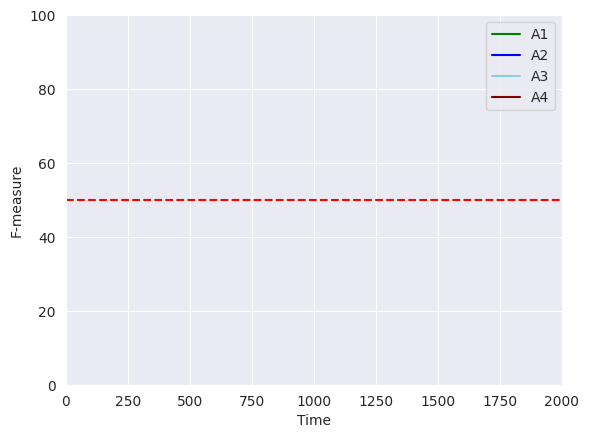

In [124]:
animate_decay(decay_rates, thresh, filename='decays.gif', fps=100)

In [106]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

(0.00124, 0.00168, 0.00224, 0.00255)

In [ ]:
fig, ax = plt.subplots()
t = np.linspace(0, 3, 40)
g = -9.81
v0 = 12
z = g * t**2 / 2 + v0 * t

v02 = 5
z2 = g * t**2 / 2 + v02 * t

scat = ax.scatter(t[0], z[0], c="b", s=5, label=f'v0 = {v0} m/s')
line2 = ax.plot(t[0], z2[0], label=f'v0 = {v02} m/s')[0]
ax.set(xlim=[0, 3], ylim=[-4, 10], xlabel='Time [s]', ylabel='Z [m]')
ax.legend()


def update(frame):
    # for each frame, update the data stored on each artist.
    x = t[:frame]
    y = z[:frame]
    # update the scatter plot:
    data = np.stack([x, y]).T
    scat.set_offsets(data)
    # update the line plot:
    line2.set_xdata(t[:frame])
    line2.set_ydata(z2[:frame])
    return (scat, line2)


ani = animation.FuncAnimation(fig=fig, func=update, frames=40, interval=30)
plt.show()